In [168]:
# !pip install git+https://github.com/statsmodels/statsmodels.git
# # # # # # !python -m pip install git+https://github.com/statsmodels/statsmodels
# !pip install geopandas
# !pip install statsmodels!
# !pip install mapclassify
!pip install pillow

# Objective
###What is the objective or goal that you are trying to accomplish? What is the decision that you must make?

I want to show the evolution of the local and imported price of food over the country and predict the price in the future.

# Hypothesis: Research Question?
 What is the question that you would like to answer in order to make a decision?

 What variable has an significant impact on the price of the food ?

# Data Source
Explain where did you get the data. How can you trust this data? Who produced this data and what were their motiviations?


# Data Cleaning
In this step you will prepare your data for analysis.

## Review data types
Inspect the dataset for the data types of each column.

## Analytical Transformations
Perform any transformation on the columns in the dataset to enable further analysis.

### Treatment of Missing Values
If there are any missing values, how do you plan to treat those data columns?

# Import librairies

In [187]:
# import librairies
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
# import fiona
import io
import re
import datetime
from datetime import datetime

from statsmodels.tsa.api import ARDL 
from statsmodels.datasets import danish_data 
import statsmodels.api as sm
import statsmodels.stats as sm_stat
import statsmodels.stats as smt
import scipy.optimize as optimize
import statsmodels.formula.api as smf

# geopandas for geodataviz
import geopandas as gpd
from geopy.geocoders import Nominatim 
import folium
import PIL
from IPython.display import Image
# import folium as f

from sklearn.linear_model import LinearRegression as linear_reg
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import pickle



#Open dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [204]:

  #Open the dataset in python
foodPrice = pd.read_csv('/content/drive/MyDrive/Capston_Project_Ayiti_Analytics/wfp_food_prices_hti (1).csv')
prix_petrol = pd.read_excel('/content/drive/MyDrive/Capston_Project_Ayiti_Analytics/Weekly-GAS-PRICES.xlsx')
exchange_rate = pd.read_csv('/content/drive/MyDrive/Capston_Project_Ayiti_Analytics/HTG=X.csv')
gpd_com = gpd.read_file('/content/drive/MyDrive/Capston_Project_Ayiti_Analytics/hti_admbnda_adm2_cnigs_20181129.shp')
gpd_dep = gpd.read_file('/content/drive/MyDrive/Capston_Project_Ayiti_Analytics/hti_admbnda_adm1_cnigs_20181129.shp')

#Processing of the exchange rate data

In [5]:
exchange_rate.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-11-01,40.500000,40.637001,39.976002,40.450001,40.450001,0
1,2005-12-01,40.442001,40.603001,40.215000,40.491001,40.491001,0
2,2006-01-01,40.452999,42.798000,40.283001,41.945000,41.945000,0
3,2006-02-01,42.000000,42.053001,39.987000,40.206001,40.206001,0
4,2006-03-01,40.224998,40.484001,39.661999,39.998001,39.998001,0


In [6]:
#change the format of date
exchange_rate['Date']=pd.to_datetime(exchange_rate['Date']).map(lambda x: x.strftime('%d-%m-%Y'))
exchange_rate['Date'] = exchange_rate['Date'].map(lambda x: "15"+x[2:])
exchange_rate= exchange_rate.rename(columns={'Date':'date','Close':'Taux de change'})
exchange_rate.drop(['Open','High','Low','Adj Close','Volume'],axis=1, inplace=True)
# exchange_rate.set_index('date',inplace=True)


In [7]:
exchange_rate.head()

,date,Taux de change
0,15-11-2005,40.450001
1,15-12-2005,40.491001
2,15-01-2006,41.945000
3,15-02-2006,40.206001
4,15-03-2006,39.998001


#End of the processing of the exchange rate data

#Processing of petrol price analysis

In [8]:
petrol = prix_petrol.copy()

In [9]:
petrol.head()

,Indicator,Indicator Name,Country,Country Name,Country notes,Country RegionId,Measure,Measure Name,Scale,Units,2016W13,2016W14,2016W15,2016W16,2016W17,2016W18,2016W19,2016W20,2016W21,2016W39,2016W40,2016W41,2016W42,2016W43,2016W44,2016W45,2016W46,2016W47,2016W48,2016W49,2016W51,2016W52,2017W1,2017W2,2017W3,2017W4,2017W6,2017W8,2017W10,2017W11,...,2019W39,2019W41,2019W42,2019W43,2019W44,2019W46,2019W47,2019W48,2019W49,2019W50,2019W51,2020W1,2020W3,2020W4,2020W5,2020W6,2020W7,2020W9,2020W10,2020W11,2020W12,2020W14,2020W15,2020W17,2020W18,2020W19,2020W20,2020W21,2020W22,2020W23,2020W24,2020W25,2020W26,2020W27,2020W28,2020W29,2020W30,2020W31,2020W32,2018W32
0,KN.A2,Diesel (Liter),HT,Haiti,-,HT,KN.A1,U.S. Dollar,units,US $,0.67,0.69,0.64,0.64,0.65,0.65,0.63,0.63,0.62,0.59,0.59,0.59,0.59,0.59,0.58,0.60,0.60,0.59,0.60,0.60,0.59,0.59,0.60,0.61,0.61,0.60,0.57,0.57,0.56,0.58,...,0.49,0.49,0.49,0.49,0.49,0.49,0.49,0.49,0.49,0.49,0.49,0.50,0.48,0.48,0.48,0.47,0.47,0.50,0.52,0.50,0.50,0.50,0.49,0.49,0.48,0.45,0.44,0.45,0.45,0.44,0.44,0.44,0.44,0.43,0.43,0.43,0.43,0.43,0.43,NaN
1,KN.A4,Gasoline (Liter),HT,Haiti,-,HT,KN.A1,U.S. Dollar,units,US $,0.88,0.87,0.81,0.81,0.82,0.83,0.80,0.81,0.79,0.75,0.75,0.74,0.75,0.74,0.74,0.76,0.76,0.75,0.75,0.77,0.75,0.75,0.76,0.77,0.78,0.76,0.72,0.72,0.71,0.74,...,0.61,0.60,0.61,0.60,0.61,0.61,0.61,0.61,0.61,0.61,0.61,0.62,0.60,0.60,0.60,0.59,0.59,0.63,0.65,0.63,0.62,0.63,0.62,0.61,0.60,0.56,0.56,0.56,0.56,0.55,0.55,0.55,0.55,0.54,0.54,0.54,0.53,0.53,0.54,0.88
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Source:,GlobalPetrolPrices.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Download URL:,http://opendata.investhaiti.ht/hsjugfd/global-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Drop the unused columns and rows and rename columns
cols=['Indicator','Indicator Name','Country','Country Name','Country notes','Country RegionId','Measure','Measure Name','Scale','Units']
petrol.drop(cols, axis=1, inplace=True)
petrol.drop(petrol.index[2:], axis=0, inplace=True)
petrol = petrol.transpose()
petrol = petrol.reset_index()
petrol.rename(columns={"index":"date",0:"Diesel_Unit_Liter_USD",1:"Gasoline_Unit_Liter_USD"}, inplace=True)
# # petrol.columns = [''] * len(petrol.columns)

In [11]:
list_ = petrol.iloc[[0],:]
print(list_)

      date  Diesel_Unit_Liter_USD  Gasoline_Unit_Liter_USD
0  2016W13                   0.67                     0.88


In [12]:
#petrol dateframe
petrol.head()

,date,Diesel_Unit_Liter_USD,Gasoline_Unit_Liter_USD
0,2016W13,0.67,0.88
1,2016W14,0.69,0.87
2,2016W15,0.64,0.81
3,2016W16,0.64,0.81
4,2016W17,0.65,0.82


In [13]:
#show the mean of petrol price per month
def getMonth(x):
  x = int(x)
  return int(x * 0.2299) + 1


dico = {}
dicoGasol = {}
for row in petrol.index:
  date  = petrol['date'][row]
  diesel = petrol['Diesel_Unit_Liter_USD'][row]
  gasoline = petrol['Gasoline_Unit_Liter_USD'][row]
  index = date.find('W')
  if index != -1:
    annee = date[:index]
    mois = getMonth(date[index+1:])
    key = '15-'+str(mois)+'-'+str(annee)
    prev = dico.get(key,0)
    prevGasol = dicoGasol.get(key,0)
    if prev == 0:

      dico[key] = diesel
    else:
      dico[key] = (diesel + prev)/2

    if prevGasol == 0:
      dicoGasol[key] = gasoline
    else:
      dicoGasol[key] = (gasoline+prevGasol)/2

dieselDF = pd.DataFrame(dico.items())
gasolDF = pd.DataFrame(dicoGasol.items())
display(dieselDF.head(2))
display(gasolDF.head(2))
# gasolDF.head()
     

,0,1
0,15-3-2016,0.67000
1,15-4-2016,0.65125


,0,1
0,15-3-2016,0.8800
1,15-4-2016,0.8225


In [14]:
#Rename columns of Diesel dataframe
gasolDF.reset_index(inplace=True)
cols = {0:'date',1:'Gasoline_Unit_Liter_USD'}
gasolDF.rename(columns=cols, inplace=True)
gasolDF.reset_index(inplace=True)
gasolDF.drop(['level_0','index'], axis=1, inplace=True)
gasolDF.head()

,date,Gasoline_Unit_Liter_USD
0,15-3-2016,0.88000
1,15-4-2016,0.82250
2,15-5-2016,0.80125
3,15-9-2016,0.75000
4,15-10-2016,0.74375


In [15]:
#Rename columns of Diesel dataframe
dieselDF.reset_index(inplace=True)
cols = {0:'date',1:'Diesel_Unit_Liter_USD'}
dieselDF.rename(columns=cols, inplace=True)
dieselDF.reset_index(inplace=True)
dieselDF.drop(['level_0','index'], axis=1, inplace=True)
dieselDF.head()

,date,Diesel_Unit_Liter_USD
0,15-3-2016,0.67000
1,15-4-2016,0.65125
2,15-5-2016,0.62750
3,15-9-2016,0.59000
4,15-10-2016,0.59000


In [16]:
#merge the two dataframe
petrolGD = pd.merge(dieselDF, gasolDF, on='date', how='inner')


In [17]:
petrolGD.head()

,date,Diesel_Unit_Liter_USD,Gasoline_Unit_Liter_USD
0,15-3-2016,0.67000,0.88000
1,15-4-2016,0.65125,0.82250
2,15-5-2016,0.62750,0.80125
3,15-9-2016,0.59000,0.75000
4,15-10-2016,0.59000,0.74375


#End of petrol price analysis

#Processing food data

In [18]:
# Make a copy of the dataframes
food = foodPrice.copy()

In [19]:
#Read the dataframe
food.head()

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,pricetype,currency,price,usdprice
0,#date,#adm1+name,#adm2+name,#loc+market+name,#geo+lat,#geo+lon,#item+type,#item+name,#item+unit,#item+price+type,#currency,#value,#value+usd
1,2005-01-15,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Maize meal (local),Marmite,actual,HTG,60.0,0.61
2,2005-01-15,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Rice (tchako),Marmite,actual,HTG,94.0,0.96
3,2005-01-15,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Wheat flour (imported),Marmite,actual,HTG,60.0,0.61
4,2005-01-15,Centre,Hinche,Hinche,19.15,-72.016667,cereals and tubers,Maize meal (imported),Pound,actual,HTG,13.16,0.13


In [20]:
#Drop the first row and drop unnecessary columns
food.drop(index=0,axis=0,inplace=True)
food.reset_index(inplace=True)
food.drop(columns=['index','currency','pricetype'],inplace=True)


Rename columns

In [21]:
dict = {'admin1':'departement',
        'admin2':'commune',
        'price':'gdesPrice',
        'usdprice':'usdPrice'}
food.rename(columns=dict, inplace=True)


Change some type error

In [22]:
#Change type of these columns
food['date']=pd.to_datetime(food['date']).map(lambda x: x.strftime('%d-%m-%Y'))
food = food.astype({'latitude':'float64','longitude':'float64','gdesPrice':'float64','usdPrice':'float64'})

Look for abnormal values

In [23]:
food.describe()

,latitude,longitude,gdesPrice,usdPrice
count,12864.000000,12864.000000,12864.000000,12864.000000
mean,18.949271,-72.696506,151.046181,1.542695
std,0.611401,0.753649,159.498471,1.629068
min,18.200000,-74.083333,6.750000,0.070000
25%,18.234167,-72.831900,33.330000,0.340000
50%,18.616667,-72.534722,90.000000,0.920000
75%,19.550000,-72.204167,214.250000,2.192500
max,19.939051,-71.733333,937.500000,9.570000


In [24]:
food.describe(include='O')

,date,departement,commune,market,category,commodity,unit
count,12864,12864,12864,12864,12864,12864,12864
unique,197,9,9,9,4,12,4
top,15-12-2016,South-East,Jacmel,Jacmel,cereals and tubers,Wheat flour (imported),Marmite
freq,95,1784,1784,1784,8995,1698,7257


In [25]:
food.head()

,date,departement,commune,market,latitude,longitude,category,commodity,unit,gdesPrice,usdPrice
0,15-01-2005,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Maize meal (local),Marmite,60.00,0.61
1,15-01-2005,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Rice (tchako),Marmite,94.00,0.96
2,15-01-2005,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Wheat flour (imported),Marmite,60.00,0.61
3,15-01-2005,Centre,Hinche,Hinche,19.15,-72.016667,cereals and tubers,Maize meal (imported),Pound,13.16,0.13
4,15-01-2005,Centre,Hinche,Hinche,19.15,-72.016667,cereals and tubers,Maize meal (local),Marmite,36.00,0.37


In [26]:
#Create a new column to show imported and local products
food = food.assign(origin = 'imported')
for item in ['local','imported']:
  food['origin'][food['commodity'].str.contains(item)] = item
food['commodity'] = food['commodity'].str.replace(r"\(.*\)","")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [27]:
food.head()

,date,departement,commune,market,latitude,longitude,category,commodity,unit,gdesPrice,usdPrice,origin
0,15-01-2005,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Maize meal,Marmite,60.00,0.61,local
1,15-01-2005,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Rice,Marmite,94.00,0.96,imported
2,15-01-2005,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Wheat flour,Marmite,60.00,0.61,imported
3,15-01-2005,Centre,Hinche,Hinche,19.15,-72.016667,cereals and tubers,Maize meal,Pound,13.16,0.13,imported
4,15-01-2005,Centre,Hinche,Hinche,19.15,-72.016667,cereals and tubers,Maize meal,Marmite,36.00,0.37,local


#End of food data processing


# Analysis of price food per year and per month

##Local food Vs Imported food



*   Analyse produit X produit
 graph
*  Analyse prix produit local X prix produit importe
 graph


*   Analyse category X category
 graph
*   Evolution prix selon category
 graph


*   Analyse prix gdes X prix USD
 graph
*   Variation des prix par departement durant ces 15 dernieres annees 
 graph


*   Test
*   Regression Lineair


In [28]:
food.head()

,date,departement,commune,market,latitude,longitude,category,commodity,unit,gdesPrice,usdPrice,origin
0,15-01-2005,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Maize meal,Marmite,60.00,0.61,local
1,15-01-2005,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Rice,Marmite,94.00,0.96,imported
2,15-01-2005,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Wheat flour,Marmite,60.00,0.61,imported
3,15-01-2005,Centre,Hinche,Hinche,19.15,-72.016667,cereals and tubers,Maize meal,Pound,13.16,0.13,imported
4,15-01-2005,Centre,Hinche,Hinche,19.15,-72.016667,cereals and tubers,Maize meal,Marmite,36.00,0.37,local


In [29]:
#find the local and imported product
filtering = food['origin'] == "local"
local_food = food.where(filtering).dropna()
filtering = food['origin'] == "imported"
imported_food = food.where(filtering).dropna()
#local product
local_product = local_food.groupby(by=['commodity']).size().to_frame()
local_product.columns = ['Total local product']


In [30]:
#Imported product
imported_product = imported_food.groupby(by=['commodity']).size().to_frame()
imported_product.columns = ['Total imported product']

In [31]:
imported_product.head()

,Total imported product
commodity,
Beans,2460
Maize meal,1127
Oil,870
Pasta,492
Rice,1563


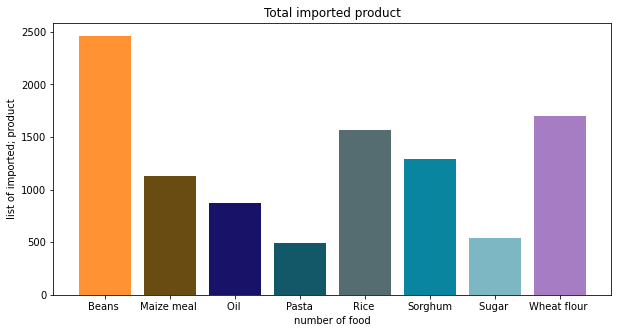

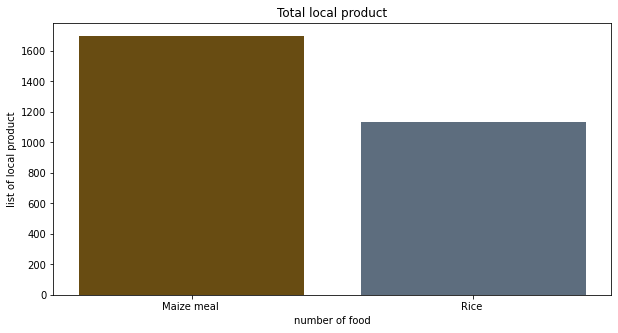

In [32]:
#Show the total of local product
plt.figure(figsize=(10,5))
plt.bar(imported_product.index,imported_product['Total imported product'],color=['#FF9333','#684C12','#181268','#125868','#556C71','#09859F','#7CB7C3','#A67CC3'])
plt.title('Total imported product')
plt.xlabel('number of food')
plt.ylabel('list of imported; product')
plt.show()
plt.figure(figsize=(10,5))
plt.bar(local_product.index,local_product['Total local product'],color=['#684C12','#5D6D7E'])
plt.title('Total local product')
plt.xlabel('number of food')
plt.ylabel('list of local product')
plt.show()



##Analyse produit par produit en fonction de l'annee

In [33]:
foods_p = pd.pivot_table(data=food[food.unit=='Marmite'],index=["date",'departement','commune','origin'],columns=["commodity"],values='gdesPrice',aggfunc="mean")

In [34]:
foods_p

commodity                                       Beans   ...  Wheat flour 
date       departement commune        origin            ...              
15-01-2005 Artibonite  Gonaives       imported     NaN  ...          60.0
                                      local        NaN  ...           NaN
           Centre      Hinche         imported     NaN  ...          53.4
                                      local        NaN  ...           NaN
           Grande'Anse Jeremie        imported     NaN  ...          72.0
...                                                ...  ...           ...
15-12-2020 South       Les Cayes      local        NaN  ...           NaN
           South-East  Jacmel         imported   549.0  ...         162.0
                                      local        NaN  ...           NaN
           West        Port-au-Prince imported   600.0  ...         165.0
                                      local        NaN  ...           NaN

[3399 rows x 6 columns]

##Analysis the local food

In [35]:
food.head()

,date,departement,commune,market,latitude,longitude,category,commodity,unit,gdesPrice,usdPrice,origin
0,15-01-2005,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Maize meal,Marmite,60.00,0.61,local
1,15-01-2005,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Rice,Marmite,94.00,0.96,imported
2,15-01-2005,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Wheat flour,Marmite,60.00,0.61,imported
3,15-01-2005,Centre,Hinche,Hinche,19.15,-72.016667,cereals and tubers,Maize meal,Pound,13.16,0.13,imported
4,15-01-2005,Centre,Hinche,Hinche,19.15,-72.016667,cereals and tubers,Maize meal,Marmite,36.00,0.37,local


In [36]:
#Create new columns to fasilitate our analysis and turning them from string to integer
food['month'] = food['date'].str[3:5]
food['year'] = food['date'].str[6:]
# food.astype({'month':'int64',' year':'int64'})
food.set_index('date', inplace=True)

In [37]:
#Search the local food on the dataset
filtering = food['origin'] == "local"
local_food = food.where(filtering).dropna().astype({'month':'int64','year':'int64'})
local_food.reset_index(inplace=True)
pd.to_datetime(local_food.date)
local_food.head()


,date,departement,commune,market,latitude,longitude,category,commodity,unit,gdesPrice,usdPrice,origin,month,year
0,15-01-2005,Artibonite,Gonaives,Gonaives,19.450000,-72.683333,cereals and tubers,Maize meal,Marmite,60.0,0.61,local,1,2005
1,15-01-2005,Centre,Hinche,Hinche,19.150000,-72.016667,cereals and tubers,Maize meal,Marmite,36.0,0.37,local,1,2005
2,15-01-2005,Centre,Hinche,Hinche,19.150000,-72.016667,cereals and tubers,Rice,Pound,24.2,0.25,local,1,2005
3,15-01-2005,Grande'Anse,Jeremie,Jeremie,18.616667,-74.083333,cereals and tubers,Maize meal,Marmite,23.2,0.24,local,1,2005
4,15-01-2005,Grande'Anse,Jeremie,Jeremie,18.616667,-74.083333,cereals and tubers,Rice,Pound,30.4,0.31,local,1,2005


In [38]:
local_food.unit.unique()

array(['Marmite', 'Pound'], dtype=object)

##Local Maize meal

###Marmite

In [39]:
#Search marmite Maize meal in the local food
marmite_mais_local = local_food[(local_food['commodity']=='Maize meal ') & (local_food['unit']=='Marmite')]
marmite_mais_local.head()


# local_food.commodity = local_food.commodity.apply(lambda x: x.strip())

,date,departement,commune,market,latitude,longitude,category,commodity,unit,gdesPrice,usdPrice,origin,month,year
0,15-01-2005,Artibonite,Gonaives,Gonaives,19.450000,-72.683333,cereals and tubers,Maize meal,Marmite,60.0,0.61,local,1,2005
1,15-01-2005,Centre,Hinche,Hinche,19.150000,-72.016667,cereals and tubers,Maize meal,Marmite,36.0,0.37,local,1,2005
3,15-01-2005,Grande'Anse,Jeremie,Jeremie,18.616667,-74.083333,cereals and tubers,Maize meal,Marmite,23.2,0.24,local,1,2005
5,15-01-2005,North,Cap-Haitien,Cap-Haitien,19.757778,-72.204167,cereals and tubers,Maize meal,Marmite,49.2,0.50,local,1,2005
7,15-01-2005,North-East,Ouanaminthe,Ouanaminthe,19.550000,-71.733333,cereals and tubers,Maize meal,Marmite,37.1,0.38,local,1,2005


In [40]:
# mean price of marmite Maize meal per year
mean_marmite_mais_local_per_year = marmite_mais_local.groupby(by=['commodity','year']).gdesPrice.mean().to_frame()
mean_marmite_mais_local_per_year.reset_index('commodity',inplace=True)
mean_marmite_mais_local_per_year.head()

,commodity,gdesPrice
year,,
2005,Maize meal,49.932963
2006,Maize meal,59.877778
2007,Maize meal,50.879167
2008,Maize meal,86.886413
2009,Maize meal,76.747619


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


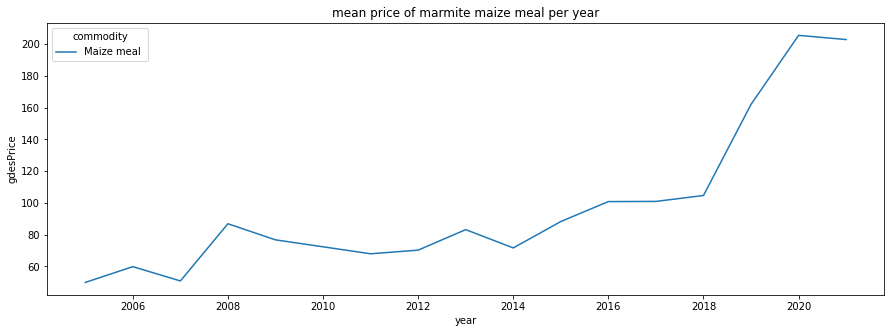

In [41]:
#graph
def lineplot_co(df,title='mean price of marmite maize meal per year'):
  plt.figure(figsize=(15,5))
  plt.title(title)
  sns.lineplot(df.index, 'gdesPrice', ci=None, 
             hue='commodity', data=df.reset_index())
  

lineplot_co(mean_marmite_mais_local_per_year, title='mean price of marmite maize meal per year')

##Local Rice

###Marmite

In [42]:
#Search marmite Rice in the local food
marmite_rice_local = local_food[(local_food['commodity']=='Rice ') & (local_food['unit']=='Marmite')]
marmite_rice_local.reset_index(inplace=True)
marmite_rice_local = marmite_rice_local.iloc[:,1:]
marmite_rice_local.head()


,date,departement,commune,market,latitude,longitude,category,commodity,unit,gdesPrice,usdPrice,origin,month,year
0,15-05-2014,Artibonite,Gonaives,Gonaives,19.450000,-72.683333,cereals and tubers,Rice,Marmite,140.00,1.43,local,5,2014
1,15-05-2014,Centre,Hinche,Hinche,19.150000,-72.016667,cereals and tubers,Rice,Marmite,140.00,1.43,local,5,2014
2,15-05-2014,North,Cap-Haitien,Cap-Haitien,19.757778,-72.204167,cereals and tubers,Rice,Marmite,110.00,1.12,local,5,2014
3,15-05-2014,North-West,Port-de-Paix,Port-de-Paix,19.939051,-72.831900,cereals and tubers,Rice,Marmite,130.00,1.33,local,5,2014
4,15-05-2014,South,Les Cayes,Cayes,18.200000,-73.750000,cereals and tubers,Rice,Marmite,174.25,1.78,local,5,2014


In [43]:
# mean price of of local rice per year
mean_marmite_rice_local_per_year = marmite_rice_local.groupby(by=['commodity','year']).gdesPrice.mean().to_frame()
mean_marmite_rice_local_per_year.reset_index('commodity',inplace=True)
mean_marmite_rice_local_per_year.head()

,commodity,gdesPrice
year,,
2014,Rice,142.634615
2015,Rice,153.071429
2016,Rice,153.622024
2017,Rice,166.374699
2018,Rice,225.549091


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


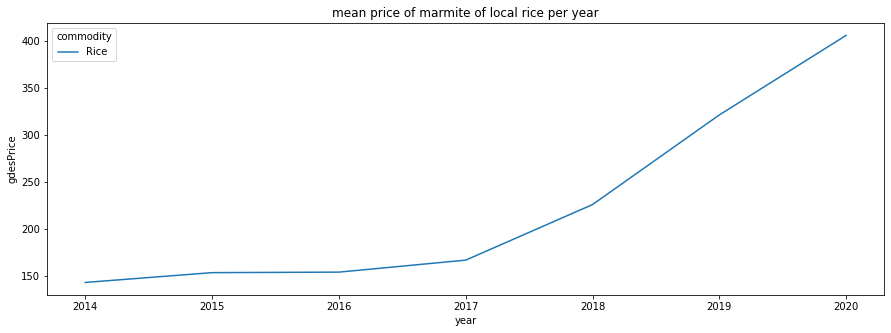

In [44]:
# graph to show mean price of marmite of local rice per year
lineplot_co(mean_marmite_rice_local_per_year, title='mean price of marmite of local rice per year')

###Pound

In [45]:
#Search pound Rice in the local food
pound_rice_local = local_food[(local_food['commodity']=='Rice ') & (local_food['unit']=='Pound')]
pound_rice_local.reset_index(inplace=True)
display(pound_rice_local.columns)
pound_rice_local = pound_rice_local.iloc[:,1:]
pound_rice_local.head()

Index(['index', 'date', 'departement', 'commune', 'market', 'latitude',
       'longitude', 'category', 'commodity', 'unit', 'gdesPrice', 'usdPrice',
       'origin', 'month', 'year'],
      dtype='object')

,date,departement,commune,market,latitude,longitude,category,commodity,unit,gdesPrice,usdPrice,origin,month,year
0,15-01-2005,Centre,Hinche,Hinche,19.150000,-72.016667,cereals and tubers,Rice,Pound,24.2,0.25,local,1,2005
1,15-01-2005,Grande'Anse,Jeremie,Jeremie,18.616667,-74.083333,cereals and tubers,Rice,Pound,30.4,0.31,local,1,2005
2,15-01-2005,North,Cap-Haitien,Cap-Haitien,19.757778,-72.204167,cereals and tubers,Rice,Pound,30.0,0.31,local,1,2005
3,15-01-2005,South,Les Cayes,Cayes,18.200000,-73.750000,cereals and tubers,Rice,Pound,14.2,0.15,local,1,2005
4,15-01-2005,South-East,Jacmel,Jacmel,18.234167,-72.534722,cereals and tubers,Rice,Pound,36.0,0.37,local,1,2005


In [46]:
# mean price of Maize meal pot per year
mean_pound_rice_local = pound_rice_local.groupby(by=['commodity','year']).gdesPrice.mean().to_frame()
mean_pound_rice_local.reset_index('commodity',inplace=True)
mean_pound_rice_local.head()

,commodity,gdesPrice
year,,
2005,Rice,26.230909
2006,Rice,32.195000
2007,Rice,36.521667
2008,Rice,41.720455
2009,Rice,43.155000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


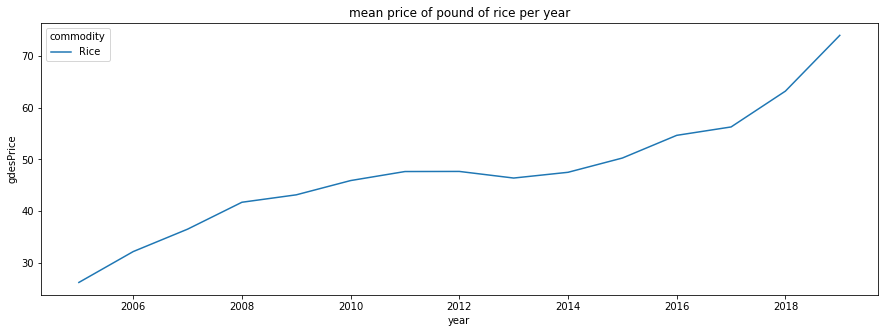

In [47]:
# graph to show mean price of pound of rice per year
lineplot_co(mean_pound_rice_local, title='mean price of pound of rice per year')

#Analysis on imported food

In [48]:
imported_food.head()

,date,departement,commune,market,latitude,longitude,category,commodity,unit,gdesPrice,usdPrice,origin
1,15-01-2005,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Rice,Marmite,94.00,0.96,imported
2,15-01-2005,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Wheat flour,Marmite,60.00,0.61,imported
3,15-01-2005,Centre,Hinche,Hinche,19.15,-72.016667,cereals and tubers,Maize meal,Pound,13.16,0.13,imported
5,15-01-2005,Centre,Hinche,Hinche,19.15,-72.016667,cereals and tubers,Rice,Pound,16.52,0.17,imported
7,15-01-2005,Centre,Hinche,Hinche,19.15,-72.016667,cereals and tubers,Rice,Marmite,82.60,0.84,imported


In [49]:
imported_food.commodity.unique()

array(['Rice ', 'Wheat flour ', 'Maize meal ', 'Sorghum', 'Beans ',
       'Oil ', 'Pasta', 'Sugar '], dtype=object)

In [50]:
#Search Maize meal in the imported food
mais_imported = imported_food[imported_food["commodity"] == "Maize meal "]
mais_imported.reset_index(inplace=True)
mais_imported = mais_imported.iloc[:,1:]
mais_imported.date = pd.to_datetime(mais_imported.date)
mais_imported.head()

,date,departement,commune,market,latitude,longitude,category,commodity,unit,gdesPrice,usdPrice,origin
0,2005-01-15,Centre,Hinche,Hinche,19.150000,-72.016667,cereals and tubers,Maize meal,Pound,13.16,0.13,imported
1,2005-01-15,North,Cap-Haitien,Cap-Haitien,19.757778,-72.204167,cereals and tubers,Maize meal,Pound,14.88,0.15,imported
2,2005-01-15,North-East,Ouanaminthe,Ouanaminthe,19.550000,-71.733333,cereals and tubers,Maize meal,Pound,21.00,0.21,imported
3,2005-01-15,South,Les Cayes,Cayes,18.200000,-73.750000,cereals and tubers,Maize meal,Pound,14.40,0.15,imported
4,2005-01-15,South-East,Jacmel,Jacmel,18.234167,-72.534722,cereals and tubers,Maize meal,Pound,12.48,0.13,imported


### Compare the price of local food to the price of imported food


In [51]:
food.head(1)

,departement,commune,market,latitude,longitude,category,commodity,unit,gdesPrice,usdPrice,origin,month,year
date,,,,,,,,,,,,,
15-01-2005,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Maize meal,Marmite,60.0,0.61,local,01,2005


In [52]:
#Search imported food in the dataset
imported_food = food.where(food['origin'] == "imported").dropna().astype({'month':'int64','year':'int64'})

In [53]:
#mean price of imported imported food per year 
mean_price_imported_food_per_year = imported_food.groupby(['commodity','year']).gdesPrice.mean().to_frame().reset_index('commodity')
mean_price_imported_food_per_year.columns = ['imported_food','gdesPrice']
mean_price_imported_food_per_year.reset_index(inplace=True)
mean_price_imported_food_per_year.set_index('year','imported_food',inplace=True)
mean_price_imported_food_per_year.drop_duplicates(inplace=True)
mean_price_imported_food_per_year.head(5)



,imported_food,gdesPrice
year,,
2008,Beans,28.140000
2009,Beans,28.163214
2010,Beans,29.727679
2011,Beans,34.199940
2012,Beans,81.063448


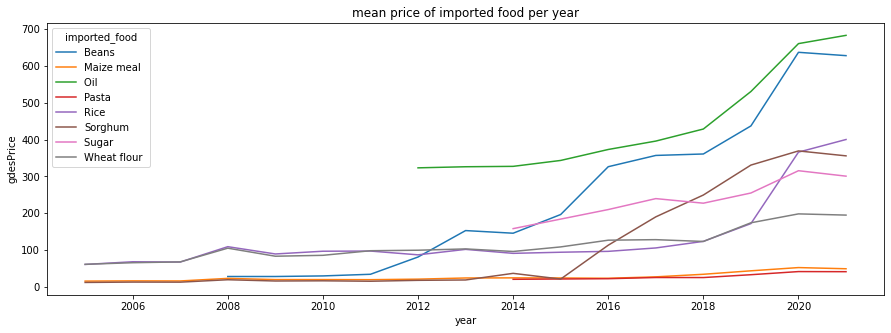

In [54]:
#  #graph to show the tendency of the mean price of imported food per year
plt.figure(figsize=(15,5))
plt.title('mean price of imported food per year')
sns.lineplot(x="year", y='gdesPrice', ci=None, 
             hue='imported_food', data=mean_price_imported_food_per_year.reset_index())

In [55]:
#show the mean of local food per year
mean_price_local_food_per_year = local_food.groupby(by=['commodity','year']).gdesPrice.mean().to_frame()
mean_price_local_food_per_year.reset_index('commodity', inplace=True)
mean_price_local_food_per_year.head()

,commodity,gdesPrice
year,,
2005,Maize meal,49.932963
2006,Maize meal,59.877778
2007,Maize meal,50.879167
2008,Maize meal,86.886413
2009,Maize meal,76.747619


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


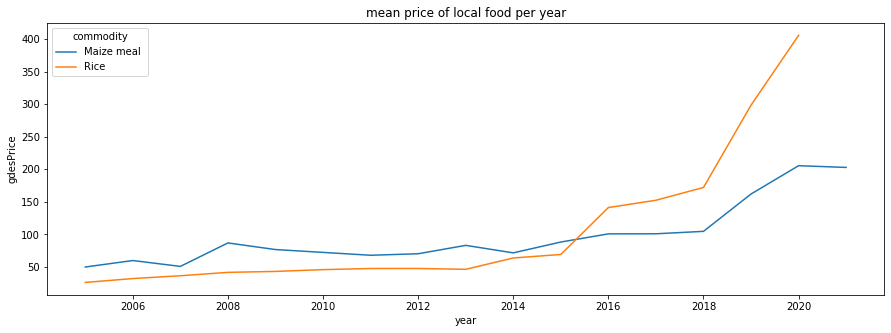

In [56]:
# graph to show mean price of local food per year
lineplot_co(mean_price_local_food_per_year, title='mean price of local food per year')

#Analyse produit par produit par annee

##local food

In [57]:
local_food.head()

,date,departement,commune,market,latitude,longitude,category,commodity,unit,gdesPrice,usdPrice,origin,month,year
0,15-01-2005,Artibonite,Gonaives,Gonaives,19.450000,-72.683333,cereals and tubers,Maize meal,Marmite,60.0,0.61,local,1,2005
1,15-01-2005,Centre,Hinche,Hinche,19.150000,-72.016667,cereals and tubers,Maize meal,Marmite,36.0,0.37,local,1,2005
2,15-01-2005,Centre,Hinche,Hinche,19.150000,-72.016667,cereals and tubers,Rice,Pound,24.2,0.25,local,1,2005
3,15-01-2005,Grande'Anse,Jeremie,Jeremie,18.616667,-74.083333,cereals and tubers,Maize meal,Marmite,23.2,0.24,local,1,2005
4,15-01-2005,Grande'Anse,Jeremie,Jeremie,18.616667,-74.083333,cereals and tubers,Rice,Pound,30.4,0.31,local,1,2005


In [58]:
local_food.commodity.unique()

array(['Maize meal ', 'Rice '], dtype=object)

###Maize meal

In [59]:
marmite_rice_local = local_food[(local_food['commodity']=='Maize meal  ') & (local_food['unit']=='Marmite')]


###Rice

In [60]:
marmite_rice_local = local_food[(local_food['commodity']=='Rice ') & (local_food['unit']=='Marmite')]


#Analyse category X category

###Local category

In [61]:
local_food.head(1)

,date,departement,commune,market,latitude,longitude,category,commodity,unit,gdesPrice,usdPrice,origin,month,year
0,15-01-2005,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Maize meal,Marmite,60.0,0.61,local,1,2005


In [62]:
#search mean price of local category of food
mean_price_local_category_of_food_year = local_food.groupby(by=['category','year']).gdesPrice.mean().to_frame()
mean_price_local_category_of_food_year.reset_index('category', inplace=True)
mean_price_local_category_of_food_year.head()

,category,gdesPrice
year,,
2005,cereals and tubers,41.935337
2006,cereals and tubers,49.991071
2007,cereals and tubers,45.751488
2008,cereals and tubers,68.019620
2009,cereals and tubers,61.243333


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


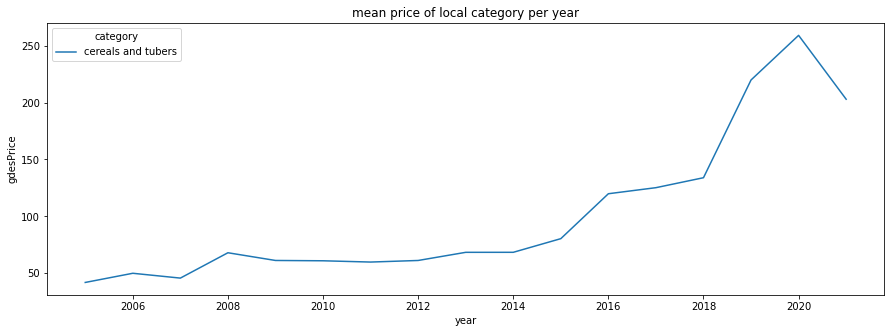

In [63]:
# graph to show the mean price of local category by year
plt.figure(figsize=(15,5))
plt.title('mean price of local category per year')
sns.lineplot(mean_price_local_category_of_food_year.index, 'gdesPrice', ci=None, 
             hue='category', data=mean_price_local_category_of_food_year)

###Imported category

In [64]:
#search mean price by category
mean_price_imported_food_of_food_year = imported_food.groupby(by=['category','year']).gdesPrice.mean().to_frame()
mean_price_imported_food_of_food_year.reset_index('category', inplace=True)
mean_price_imported_food_of_food_year.columns = ['category','mean_gdesPrice']
mean_price_imported_food_of_food_year.head()

,category,mean_gdesPrice
year,,
2005,cereals and tubers,42.577745
2006,cereals and tubers,46.536531
2007,cereals and tubers,46.667514
2008,cereals and tubers,71.018538
2009,cereals and tubers,56.685952


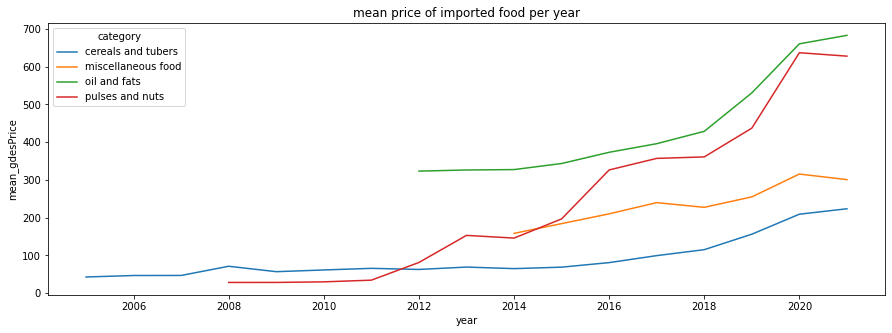

In [65]:
# #graph to show the tendency of the mean price imported food by year
plt.figure(figsize=(15,5))
plt.title('mean price of imported food per year')
sns.lineplot(x="year", y='mean_gdesPrice', ci=None, 
             hue='category', data=mean_price_imported_food_of_food_year.reset_index())

#  Variation des prix par departement durant ces 15 dernieres annees 


###Local food

In [66]:
food.head()

,departement,commune,market,latitude,longitude,category,commodity,unit,gdesPrice,usdPrice,origin,month,year
date,,,,,,,,,,,,,
15-01-2005,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Maize meal,Marmite,60.00,0.61,local,01,2005
15-01-2005,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Rice,Marmite,94.00,0.96,imported,01,2005
15-01-2005,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Wheat flour,Marmite,60.00,0.61,imported,01,2005
15-01-2005,Centre,Hinche,Hinche,19.15,-72.016667,cereals and tubers,Maize meal,Pound,13.16,0.13,imported,01,2005
15-01-2005,Centre,Hinche,Hinche,19.15,-72.016667,cereals and tubers,Maize meal,Marmite,36.00,0.37,local,01,2005


In [67]:
#search the evolution of the local food price of local by departement
local_price_per_departement = local_food.groupby(by=['market','latitude','longitude','category','year','departement']).gdesPrice.sum().to_frame()
local_price_per_departement.head()

gdesPrice
market      latitude  longitude  category           year departement           
Cap-Haitien 19.757778 -72.204167 cereals and tubers 2005 North          1043.00
                                                    2006 North          1257.55
                                                    2007 North          1302.30
                                                    2008 North          1695.92
                                                    2009 North          1644.47

In [68]:
local_price_per_departement.reset_index(inplace=True)

In [69]:
local_price_per_departement.head()

,market,latitude,longitude,category,year,departement,gdesPrice
0,Cap-Haitien,19.757778,-72.204167,cereals and tubers,2005,North,1043.00
1,Cap-Haitien,19.757778,-72.204167,cereals and tubers,2006,North,1257.55
2,Cap-Haitien,19.757778,-72.204167,cereals and tubers,2007,North,1302.30
3,Cap-Haitien,19.757778,-72.204167,cereals and tubers,2008,North,1695.92
4,Cap-Haitien,19.757778,-72.204167,cereals and tubers,2009,North,1644.47


In [70]:
#search the evolution of the imported food price of local by departement
local_price_per_departement = local_food.groupby(by=['category','year','departement']).gdesPrice.mean().to_frame()
local_price_per_departement.reset_index(inplace=True)
local_price_per_departement.head()

,category,year,departement,gdesPrice
0,cereals and tubers,2005,Artibonite,50.937500
1,cereals and tubers,2005,Centre,36.441667
2,cereals and tubers,2005,Grande'Anse,30.115909
3,cereals and tubers,2005,North,43.458333
4,cereals and tubers,2005,North-East,39.659167


In [71]:
#map
# Create latitude and longitude data
gpd_com['x']=gpd_com.geometry.centroid.x
gpd_com['y'] =gpd_com.geometry.centroid.y
gpd_com_json = gpd_com.to_json()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


marmite

In [72]:
marmite_mais_local.head(2)

,date,departement,commune,market,latitude,longitude,category,commodity,unit,gdesPrice,usdPrice,origin,month,year
0,15-01-2005,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Maize meal,Marmite,60.0,0.61,local,1,2005
1,15-01-2005,Centre,Hinche,Hinche,19.15,-72.016667,cereals and tubers,Maize meal,Marmite,36.0,0.37,local,1,2005


In [73]:
marmite_mais_local_m_ = marmite_mais_local[['date','departement','gdesPrice']]
marmite_mais_local_m_.head()

,date,departement,gdesPrice
0,15-01-2005,Artibonite,60.0
1,15-01-2005,Centre,36.0
3,15-01-2005,Grande'Anse,23.2
5,15-01-2005,North,49.2
7,15-01-2005,North-East,37.1


In [74]:
marmite_mais_local_m = pd.pivot_table(data=marmite_mais_local_m_, index='departement', columns='date', aggfunc='mean')
marmite_mais_local_m

gdesPrice                        ...                                 
date        15-01-2005 15-01-2006 15-01-2007  ... 15-12-2017 15-12-2018 15-12-2020
departement                                   ...                                 
Artibonite        60.0       48.0       45.0  ...      111.0      120.0      185.0
Centre            36.0       54.0       64.0  ...       94.0      112.2      175.0
Grande'Anse       23.2       82.4       38.4  ...        NaN      100.0      122.5
North             49.2       60.0       78.0  ...      100.0      143.0      300.0
North-East        37.1       48.8       35.0  ...       94.0      107.0      175.0
North-West        55.0       51.0       50.0  ...      120.0       93.0      200.0
South             48.0       52.0       60.0  ...       70.0       95.0      118.8
South-East        36.0       48.0       45.6  ...       90.0      120.0      180.0
West              69.0       78.0       70.0  ...      100.0      111.0      120.0

[9 rows x 195 columns]

In [75]:
marmite_mais_local_m.columns
marmite_mais_local_m.columns = marmite_mais_local_m.columns.droplevel(0)
marmite_mais_local_m = marmite_mais_local_m.rename_axis(None, axis=1)

In [76]:

gpd_dep_m = gpd_dep[['ADM1_EN','geometry']]
gpd_dep_m.rename(columns={'ADM1_EN':'departement'}, inplace=True)
gpd_dep_m

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,departement,geometry
0,Artibonite,"POLYGON ((-72.69573 19.81251, -72.69408 19.811..."
1,Centre,"POLYGON ((-71.98404 19.33367, -71.98348 19.332..."
2,Grande'Anse,"MULTIPOLYGON (((-73.75492 18.64331, -73.75429 ..."
3,Nippes,"POLYGON ((-73.56737 18.58722, -73.56536 18.585..."
4,North,"POLYGON ((-72.55529 19.87769, -72.55468 19.877..."
5,North-East,"POLYGON ((-71.96148 19.73427, -71.96014 19.733..."
6,North-West,"MULTIPOLYGON (((-72.81638 19.95254, -72.81031 ..."
7,South,"MULTIPOLYGON (((-73.70372 18.10930, -73.70315 ..."
8,South-East,"POLYGON ((-72.76129 18.28151, -72.76129 18.281..."
9,West,"MULTIPOLYGON (((-73.20477 18.96978, -73.20427 ..."


In [77]:
#Merge the two dataframe
marmite_mais_local_m_gpd_dep_m = gpd_dep_m.join(marmite_mais_local_m, on= 'departement', how='right')
marmite_mais_local_m_gpd_dep_m.head(2)

,departement,geometry,15-01-2005,15-01-2006,15-01-2007,15-01-2008,15-01-2009,15-01-2010,15-01-2011,15-01-2012,15-01-2013,15-01-2014,15-01-2015,15-01-2016,15-01-2017,15-01-2018,15-01-2019,15-01-2020,15-01-2021,15-02-2005,15-02-2006,15-02-2007,15-02-2008,15-02-2009,15-02-2010,15-02-2011,15-02-2012,15-02-2013,15-02-2014,15-02-2015,15-02-2016,15-02-2017,15-02-2018,15-02-2019,15-02-2020,15-02-2021,15-03-2005,15-03-2006,15-03-2007,15-03-2008,...,15-10-2012,15-10-2013,15-10-2014,15-10-2015,15-10-2016,15-10-2017,15-10-2018,15-10-2019,15-10-2020,15-11-2005,15-11-2006,15-11-2007,15-11-2008,15-11-2009,15-11-2010,15-11-2011,15-11-2012,15-11-2013,15-11-2014,15-11-2015,15-11-2016,15-11-2017,15-11-2018,15-11-2019,15-11-2020,15-12-2005,15-12-2006,15-12-2007,15-12-2008,15-12-2009,15-12-2010,15-12-2011,15-12-2012,15-12-2013,15-12-2014,15-12-2015,15-12-2016,15-12-2017,15-12-2018,15-12-2020
0,Artibonite,"POLYGON ((-72.69573 19.81251, -72.69408 19.811...",60.0,48.0,45.0,35.00,NaN,NaN,56.0,75.00,90.0,76.0,90.0,105.0,120.0,115.2,127.50,200.0,175.0,60.0,60.00,45.0,35.0,NaN,NaN,55.0,75.0,85.0,75.0,90.0,120.0,115.0,120.0,141.56,200.00,175.0,60.0,60.0,37.50,35.0,...,75.0,75.0,67.5,90.0,120.0,110.0,120.0,195.00,200.0,40.00,60.00,35.0,NaN,NaN,52.5,60.0,75.0,75.0,75.0,90.0,120.0,110.0,120.0,200.0,200.0,40.0,45.0,35.0,NaN,NaN,53.75,66.25,75.0,75.0,78.0,90.0,120.0,111.0,120.0,185.0
1,Centre,"POLYGON ((-71.98404 19.33367, -71.98348 19.332...",36.0,54.0,64.0,60.75,82.5,69.0,65.0,68.25,70.8,67.0,74.0,99.0,94.0,98.4,130.42,150.0,175.0,35.0,63.25,50.0,73.5,73.75,96.0,85.0,66.5,70.0,67.5,70.0,95.0,85.0,100.0,137.50,168.75,175.0,37.5,66.5,41.25,88.8,...,72.0,73.0,70.0,100.0,85.0,82.5,115.0,183.33,175.0,62.25,46.25,49.5,86.25,73.0,67.0,70.0,70.0,75.0,70.0,100.0,70.0,87.0,103.8,125.0,175.0,53.5,42.5,48.6,86.0,63.0,71.25,67.00,70.5,73.0,70.0,100.0,75.0,94.0,112.2,175.0


In [ ]:
# type(marmite_mais_local_m_gpd_dep_m.columns)
marmite_mais_local_m_gpd_dep_m.columns.to_list()

In [149]:
display(marmite_mais_local_m_gpd_dep_m.columns.to_list()[0])
display(marmite_mais_local_m_gpd_dep_m.columns.to_list()[1])

'departement'

'geometry'

In [151]:
len(marmite_mais_local_m_gpd_dep_m.columns.to_list())

197

In [150]:
marmite_mais_local_m_gpd_dep_m.columns.to_list()[2:]

'15-01-2005'

In [ ]:
#Create a gif file to show the evolution of the mean price of the marmite local Maize per departement
image_frames= []

for dates in marmite_mais_local_m_gpd_dep_m.columns.to_list()[2:]:
  # print(marmite_mais_local_m_gpd_dep_m.columns.to_list()[2:8])

# plot
  # ax = marmite_mais_local_m_gpd_dep_m.plot(column=dates,
  #                                         cmap= 'OrRd',
  #                                         figsize= (14,10),
  #                                         legend=True,
  #                                         # scheme = 'user_defined',
  #                                         # classification_kwds = {'bins':[10,20,50,100,500,1000,5000,10000]},
  #                                         edgecolor='black',
  #                                         linewidth=0.5)
  
                                        
  #Add  a title to the map
  ax.set_title('Mean marmite local Maize price per departement '+dates, fontdict=
              {'fontsize':20}, pad= 12.5)
  #removing the axes
  ax.set_axis_off()
  # move the legend
  # ax.get_legend().set_bbox_to_anchor((0.18,0.6))
  img = ax.get_figure()

  f = io.BytesIO()
  img.savefig(f,format= 'png', bbox_inches='tight')
  f.seek(0)
  image_frames.append(PIL.Image.open(f))

#Create a GIF animation
image_frames[0].save('Mean marmite local Maize price per departement.gif', format= 'GIF',
                     append_images= image_frames[1:],
                     save_all = True, duration = 300,
                     loop=3)

f.close()



In [205]:
Image(open('/content/drive/MyDrive/Capston_Project_Ayiti_Analytics/Mean marmite local Maize price per departement.gif','rb').read())

Output hidden; open in https://colab.research.google.com to view.

# Data Analysis
Explore the dataset to discover relationships between records or columns and patterns within the data.

## Descriptive Statistical Analysis
Using basic statistical measures such as measurements of central tendancy such as mean, median and mode.

### Distribution of Variables
Identify the distribution of the data to understand the range of values and how the data is structured.

### Outliers in the dataset
Identify if there are any outliers in the dataset based on statistical measures.

# Reflections
## Summary of Data Analysis
- What insights should the user takeaway from EDA.

## Questions unanswered
- What aspects of the research question were we unable to answer and why?

## Recommendations
- What should the reader do next with this information?

## Next Steps
- What will the analyst do next based on the analysis?

  `

#Merge the datasets

##Modele ARDL

###Pound imported rice at Port-au-Prince + Exchange rate

In [203]:
pound_imported_rice_p_au_p = food[(food.market=='Port-au-Prince') & (food.commodity=="Rice ") & (food.unit=="Pound") & (food.origin=="imported")]
pound_imported_rice_p_au_p_cg = pound_imported_rice_p_au_p[["commodity","gdesPrice"]]

In [80]:
 pound_imported_rice_p_au_p_cg.reset_index('date', inplace=True)

In [81]:
df_final = pd.merge(pound_imported_rice_p_au_p_cg, exchange_rate, on='date', how='left')

In [82]:
df_final.head()

,date,commodity,gdesPrice,Taux de change
0,15-01-2005,Rice,14.20,NaN
1,15-02-2005,Rice,14.00,NaN
2,15-03-2005,Rice,14.25,NaN
3,15-04-2005,Rice,14.50,NaN
4,15-05-2005,Rice,16.60,NaN


In [83]:
df_final.head()
df_final.dropna

<bound method DataFrame.dropna of            date commodity  gdesPrice  Taux de change
0    15-01-2005     Rice       14.20             NaN
1    15-02-2005     Rice       14.00             NaN
2    15-03-2005     Rice       14.25             NaN
3    15-04-2005     Rice       14.50             NaN
4    15-05-2005     Rice       16.60             NaN
..          ...       ...        ...             ...
162  15-02-2019     Rice       39.79       81.433998
163  15-03-2019     Rice       33.33       82.941002
164  15-04-2019     Rice       33.33       84.070999
165  15-05-2019     Rice       34.38       90.323997
166  15-06-2019     Rice       40.63       92.897003

[167 rows x 4 columns]>

In [84]:
final=df_final.dropna().set_index("date")

In [85]:
final.isna().sum()

commodity         0
gdesPrice         0
Taux de change    0
dtype: int64

In [86]:
endog=final.gdesPrice
exog=final[["Taux de change"]]

In [87]:
exog

,Taux de change
date,
15-11-2005,40.450001
15-12-2005,40.491001
15-01-2006,41.945000
15-02-2006,40.206001
15-03-2006,39.998001
...,...
15-02-2019,81.433998
15-03-2019,82.941002
15-04-2019,84.070999


In [88]:
endog

date
15-11-2005    24.00
15-12-2005    24.50
15-01-2006    24.60
15-02-2006    27.50
15-03-2006    29.00
              ...  
15-02-2019    39.79
15-03-2019    33.33
15-04-2019    33.33
15-05-2019    34.38
15-06-2019    40.63
Name: gdesPrice, Length: 157, dtype: float64

In [89]:
model=ARDL(endog, 3, exog,3)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [90]:
res=model.fit()

In [91]:
res.conf_int()

,0,1
const,-0.720204,3.007942
gdesPrice.L1,0.702658,1.038354
gdesPrice.L2,-0.296203,0.148527
gdesPrice.L3,-0.095609,0.241711
Taux de change.L0,-0.149418,0.337698
Taux de change.L1,-0.223705,0.525506
Taux de change.L2,-0.616408,0.142614
Taux de change.L3,-0.230237,0.291935


In [107]:
train ,test = endog[0:len(endog)-3], endog[len(endog)-3:]

In [93]:
# X_train , X_test = exog[0:len(exog)-3], endog[len(exog)-3:]

In [108]:
display(train.shape)
display(test.shape)


(154,)

(3,)

In [109]:
len(train)

154

In [111]:
pred = res.predict(start=153,end =154 , dynamic =1)

In [112]:
pred

date
15-03-2019   NaN
15-04-2019   NaN
dtype: float64

In [113]:
df_final.tail()

,date,commodity,gdesPrice,Taux de change
162,15-02-2019,Rice,39.79,81.433998
163,15-03-2019,Rice,33.33,82.941002
164,15-04-2019,Rice,33.33,84.070999
165,15-05-2019,Rice,34.38,90.323997
166,15-06-2019,Rice,40.63,92.897003


In [114]:
pred

date
15-03-2019   NaN
15-04-2019   NaN
dtype: float64

In [115]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:              gdesPrice   No. Observations:                  157
Model:                     ARDL(3, 3)   Log Likelihood                -310.768
Method:               Conditional MLE   S.D. of innovations              1.820
Date:                Wed, 22 Sep 2021   AIC                            639.537
Time:                        20:11:51   BIC                            666.869
Sample:                             3   HQIC                           650.639
                                  157                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.1439      0.943      1.213      0.227      -0.720       3.008
gdesPrice.L1          0.8705      0.085     10.250      0.000       0.703       1.038
gdesPrice.L2         -0.0738      0.113     -0.656      0.513      -0.296       0.149
gdesPrice.L3          0.0731      0.085      0.856      0.393      -0.096       0.242
Taux de change.L0     0.0941      0.123      0.764      0.446      -0.149       0.338
Taux de change.L1     0.1509      0.190      0.796      0.427      -0.224       0.526
Taux de change.L2    -0.2369      0.192     -1.234      0.219      -0.616       0.143
Taux de change.L3     0.0308      0.132      0.234      0.816      -0.230       0.292
=====================================================================================
"""

No handles with labels found to put in legend.


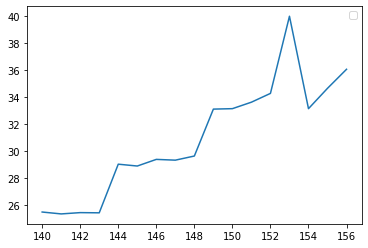

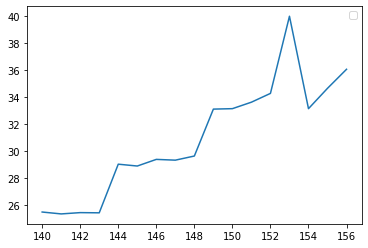

In [116]:
res.plot_predict(start=140, end=156,exog=exog)

In [117]:
dir(res)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_ar_lags',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_df_model',
 '_get_robustcov_results',
 '_hold_back',
 '_lag_repr',
 '_max_lag',
 '_n_totobs',
 '_nobs',
 '_params',
 '_plot_predictions',
 '_use_t',
 'aic',
 'aicc',
 'ar_lags',
 'arfreq',
 'bic',
 'bse',
 'conf_int',
 'cov_params',
 'cov_params_default',
 'data',
 'df_model',
 'df_resid',
 'diagnostic_summary',
 'f_test',
 'fittedvalues',
 'forecast',
 'fpe',
 'get_prediction',
 'hqic',
 'initialize',
 'llf',
 'load',
 'model',
 'nobs',
 'normalized_cov_params',
 'params',
 'plot_diagnostics',
 'plot_predict',
 'predict',
 'pvalues',
 'remove_data',
 'resid',
 '

In [118]:
res.params

const                1.143869
gdesPrice.L1         0.870506
gdesPrice.L2        -0.073838
gdesPrice.L3         0.073051
Taux de change.L0    0.094140
Taux de change.L1    0.150901
Taux de change.L2   -0.236897
Taux de change.L3    0.030849
dtype: float64

In [119]:
# prix=f(prix)

### Marmite local and imported rice at Port-au-Prince

In [120]:
food.market.unique()

array(['Gonaives', 'Hinche', 'Jeremie', 'Cap-Haitien', 'Ouanaminthe',
       'Port-de-Paix', 'Cayes', 'Jacmel', 'Port-au-Prince'], dtype=object)

In [97]:
#Search Marmite rice local and imported on the local food dataset
marmite_rice_local_imported_p_au_p_ = food[(food['commodity'] == "Rice ") & (food['unit'] == "Marmite") & (food['market'] == "Port-au-Prince")]
marmite_rice_local_imported_p_au_p_.reset_index('date', inplace=True)
marmite_rice_local_imported_p_au_p = marmite_rice_local_imported_p_au_p_[['date','market','commodity','origin','gdesPrice']]
# marmite_rice_local_imported.set_index('date', inplace=True)
marmite_rice_local_imported_p_au_p.head() 

,date,market,commodity,origin,gdesPrice
0,15-11-2005,Port-au-Prince,Rice,imported,75.00
1,15-11-2006,Port-au-Prince,Rice,imported,81.25
2,15-11-2008,Port-au-Prince,Rice,imported,161.25
3,15-11-2009,Port-au-Prince,Rice,imported,120.00
4,15-11-2010,Port-au-Prince,Rice,imported,125.00


### Marmite local and imported rice P-au-P + Exchange rate

In [98]:
marmite_rice_local_imported_p_au_p_exchange_rate = pd.merge(marmite_rice_local_imported_p_au_p, exchange_rate, on='date', how='left')
marmite_rice_local_imported_p_au_p_exchange_rate.set_index('date', inplace=True)
marmite_rice_local_imported_p_au_p_exchange_rate.dropna(inplace=True)
marmite_rice_local_imported_p_au_p_exchange_rate.head()

,market,commodity,origin,gdesPrice,Taux de change
date,,,,,
15-11-2005,Port-au-Prince,Rice,imported,75.00,40.450001
15-11-2006,Port-au-Prince,Rice,imported,81.25,36.743000
15-11-2008,Port-au-Prince,Rice,imported,161.25,39.182999
15-11-2009,Port-au-Prince,Rice,imported,120.00,39.104000
15-11-2010,Port-au-Prince,Rice,imported,125.00,39.012001


In [99]:
marmite_rice_local_imported_p_au_p_exchange_rate.shape

(68, 5)

In [100]:
exchange_rate

,date,Taux de change
0,15-11-2005,40.450001
1,15-12-2005,40.491001
2,15-01-2006,41.945000
3,15-02-2006,40.206001
4,15-03-2006,39.998001
...,...,...
187,15-06-2021,92.686592
188,15-07-2021,95.131935
189,15-08-2021,97.105392
190,15-09-2021,96.632889


###Marmite rice local + exchange rate

In [101]:
#Merge the two dataset
marmite_rice_local_exchange_rate = pd.merge(marmite_rice_local, exchange_rate, on='date', how='left')
marmite_rice_local_exchange_rate.set_index('date', inplace=True)
marmite_rice_local_exchange_rate.head()

,departement,commune,market,latitude,longitude,category,commodity,unit,gdesPrice,usdPrice,origin,month,year,Taux de change
date,,,,,,,,,,,,,,
15-05-2014,Artibonite,Gonaives,Gonaives,19.450000,-72.683333,cereals and tubers,Rice,Marmite,140.00,1.43,local,5,2014,44.214001
15-05-2014,Centre,Hinche,Hinche,19.150000,-72.016667,cereals and tubers,Rice,Marmite,140.00,1.43,local,5,2014,44.214001
15-05-2014,North,Cap-Haitien,Cap-Haitien,19.757778,-72.204167,cereals and tubers,Rice,Marmite,110.00,1.12,local,5,2014,44.214001
15-05-2014,North-West,Port-de-Paix,Port-de-Paix,19.939051,-72.831900,cereals and tubers,Rice,Marmite,130.00,1.33,local,5,2014,44.214001
15-05-2014,South,Les Cayes,Cayes,18.200000,-73.750000,cereals and tubers,Rice,Marmite,174.25,1.78,local,5,2014,44.214001


#modele a realiser

###Pound rice local + Exchange rate

In [102]:
#Merge the two dataset
pound_rice_local_exchange_rate = pd.merge(pound_rice_local, exchange_rate, on='date', how='left')
pound_rice_local_exchange_rate.set_index('date', inplace=True)
pound_rice_local_exchange_rate.head()

,departement,commune,market,latitude,longitude,category,commodity,unit,gdesPrice,usdPrice,origin,month,year,Taux de change
date,,,,,,,,,,,,,,
15-01-2005,Centre,Hinche,Hinche,19.150000,-72.016667,cereals and tubers,Rice,Pound,24.2,0.25,local,1,2005,NaN
15-01-2005,Grande'Anse,Jeremie,Jeremie,18.616667,-74.083333,cereals and tubers,Rice,Pound,30.4,0.31,local,1,2005,NaN
15-01-2005,North,Cap-Haitien,Cap-Haitien,19.757778,-72.204167,cereals and tubers,Rice,Pound,30.0,0.31,local,1,2005,NaN
15-01-2005,South,Les Cayes,Cayes,18.200000,-73.750000,cereals and tubers,Rice,Pound,14.2,0.15,local,1,2005,NaN
15-01-2005,South-East,Jacmel,Jacmel,18.234167,-72.534722,cereals and tubers,Rice,Pound,36.0,0.37,local,1,2005,NaN


In [103]:
pound_rice_local_exchange_rate.isnull().sum()

departement        0
commune            0
market             0
latitude           0
longitude          0
category           0
commodity          0
unit               0
gdesPrice          0
usdPrice           0
origin             0
month              0
year               0
Taux de change    45
dtype: int64

# modele a realiser

###Marmite mais local + Exchange_rate

In [104]:
#Merge the two dataset
marmite_mais_local_exchange_rate = pd.merge(marmite_mais_local, exchange_rate, on='date', how='left')
marmite_mais_local_exchange_rate.set_index('date', inplace=True)
marmite_mais_local_exchange_rate.head()

,departement,commune,market,latitude,longitude,category,commodity,unit,gdesPrice,usdPrice,origin,month,year,Taux de change
date,,,,,,,,,,,,,,
15-01-2005,Artibonite,Gonaives,Gonaives,19.450000,-72.683333,cereals and tubers,Maize meal,Marmite,60.0,0.61,local,1,2005,NaN
15-01-2005,Centre,Hinche,Hinche,19.150000,-72.016667,cereals and tubers,Maize meal,Marmite,36.0,0.37,local,1,2005,NaN
15-01-2005,Grande'Anse,Jeremie,Jeremie,18.616667,-74.083333,cereals and tubers,Maize meal,Marmite,23.2,0.24,local,1,2005,NaN
15-01-2005,North,Cap-Haitien,Cap-Haitien,19.757778,-72.204167,cereals and tubers,Maize meal,Marmite,49.2,0.50,local,1,2005,NaN
15-01-2005,North-East,Ouanaminthe,Ouanaminthe,19.550000,-71.733333,cereals and tubers,Maize meal,Marmite,37.1,0.38,local,1,2005,NaN


In [105]:
marmite_mais_local_exchange_rate.isnull().sum()

departement        0
commune            0
market             0
latitude           0
longitude          0
category           0
commodity          0
unit               0
gdesPrice          0
usdPrice           0
origin             0
month              0
year               0
Taux de change    90
dtype: int64

##Modele a realiser